In [22]:
from sklearn.datasets import make_circles, make_moons, make_swiss_roll, make_s_curve
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

## Define Kernel functions

In [23]:
def gaussian_kernel(x1, x2, sigma=0.1):
    return np.exp(-LA.norm(x1-x2, axis=-1)**2 / (2*sigma**2))

def poly_kernel(x1, x2, degree=3, r=2, gamma=1):
    return (np.dot(x1.T, x2) * gamma + r) ** degree

def laplacian_kernel(x1, x2, sigma=0.1):
    return np.exp(-LA.norm(x1-x2, axis=-1, ord=1) / sigma)

## Implement SVM class

In [24]:
class svm:
    def __init__(self, C=10, kernel='rbf', sigma=0.1, degree=3, r=1, gamma=1):
        self.C = C
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.r = r
        self.gamma = gamma
    
    def _kernel_function(self, x1, x2):
        if self.kernel == "rbf":
            return gaussian_kernel(x1, x2, self.sigma)
        elif self.kernel == "poly":
            return poly_kernel(x1, x2, self.degree, self.r, self.gamma)
        elif self.kernel == "laplacian":
            return laplacian_kernel(x1, x2, self.sigma)
        else:
            print("undefined kernel")
            return None
        
    def _get_kernel_matrix(self, X_train, y_train):
        m,n = X_train.shape
        y_train = y_train.reshape(-1,1) * 1.
        K = np.zeros((m, m))
        for i, x_i in enumerate(X_train):
            for j, x_j in enumerate(X_train):
                K[i, j] = self._kernel_function(x_i, x_j)
        return K
    
    def fit(self, X_train, y_train):
        print("computing gram matrix")
        m,n = X_train.shape
        y_train = y_train.reshape(-1,1) * 1.
        K = self._get_kernel_matrix(X_train, y_train)
        K = np.outer(y_train, y_train) * K
        P = matrix(K)
        q = matrix(-np.ones(m))
        G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = matrix(y_train, (1, m))
        b = matrix(0.)
        # run solver
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])
        alphas = alphas.reshape(alphas.shape[0])
        sup_vec_idx = np.argwhere(alphas > 1e-4)
        sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])
        X_sup_vec = X_train[sup_vec_idx]
        y_sup_vec = y_train[sup_vec_idx]
        alphas_sup_vec = alphas[sup_vec_idx]
        print("computing the bias term")
        y_sup_vec = y_sup_vec.reshape(y_sup_vec.shape[0])
        sup_vec_num = sup_vec_idx.shape[0]
        pred_mtx = np.zeros(sup_vec_num)
        b = 0
        for i in range(sup_vec_num):
            for j in range(sup_vec_num):
                pred_mtx[j] = self._kernel_function(X_sup_vec[j], X_sup_vec[0])
            b += y_sup_vec[i] - np.sum(alphas_sup_vec * y_sup_vec * pred_mtx)
        b /= sup_vec_num
        self.b = b
        self.sup_vec_idx = sup_vec_idx
        self.X_sup_vec = X_sup_vec
        self.y_sup_vec = y_sup_vec
        self.alphas_sup_vec = alphas_sup_vec
        self.X_train = X_train
        self.y_train = y_train
        
    def evaluate(self, X_test, y_test):
        preds = []
        sup_vec_num = self.sup_vec_idx.shape[0]
        pred_mtx = np.zeros(sup_vec_num)
        for Xt in X_test:
            for i in range(sup_vec_num):
                pred_mtx[i] = self._kernel_function(self.X_sup_vec[i], Xt)
            pred = np.sign(np.sum(self.alphas_sup_vec * self.y_sup_vec * pred_mtx))
            preds.append(int(pred))
        preds = np.array(preds)
        acc = np.sum((preds == y_test).astype("int")) / y_test.shape[0]
        return acc
    
    def get_support_vectors(self):
        return self.X_sup_vec
    
    def visualize_support_vectors(self):
        X_non_sup_vec = X_train[~np.isin(np.arange(len(X_train)), clf.sup_vec_idx)]
        y_non_sup_vec = y_train[~np.isin(np.arange(len(y_train)), clf.sup_vec_idx)]
        fig, ax = plt.subplots()
        colors = ['red','blue']
        ax.scatter(clf.X_sup_vec[:, 0], clf.X_sup_vec[:, 1], c="black", s=10, marker='x', label="Support Vectors")
        ax.scatter(X_non_sup_vec[:, 0], X_non_sup_vec[:, 1], c=y_non_sup_vec, cmap=matplotlib.colors.ListedColormap(colors), s=2)
        ax.legend(loc="upper right")
        plt.show()

## Import Two Moon Dataset

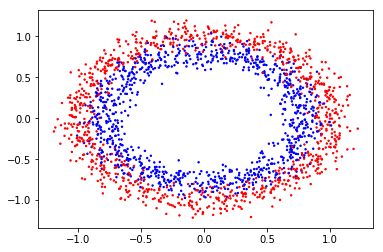

In [26]:
X, y = make_circles(n_samples=2000, noise=0.09)
colors = ['red','blue']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=2)
y[y == 0] = -1
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Fit to the Training Data

In [27]:
clf = svm()
clf.fit(X_train, y_train)

computing gram matrix
     pcost       dcost       gap    pres   dres
 0: -5.0616e+02 -6.2033e+04  9e+04  2e-01  9e-15
 1: -1.7059e+03 -1.1411e+04  1e+04  1e-02  8e-15
 2: -3.1063e+03 -6.2342e+03  3e+03  3e-03  8e-15
 3: -3.5442e+03 -5.2967e+03  2e+03  2e-03  8e-15
 4: -3.8183e+03 -4.6270e+03  8e+02  4e-04  9e-15
 5: -3.9496e+03 -4.2796e+03  3e+02  6e-05  1e-14
 6: -4.0016e+03 -4.1488e+03  1e+02  2e-05  9e-15
 7: -4.0310e+03 -4.0837e+03  5e+01  4e-06  1e-14
 8: -4.0422e+03 -4.0609e+03  2e+01  7e-07  1e-14
 9: -4.0474e+03 -4.0517e+03  4e+00  1e-07  1e-14
10: -4.0487e+03 -4.0497e+03  1e+00  2e-09  1e-14
11: -4.0491e+03 -4.0491e+03  8e-02  7e-11  1e-14
12: -4.0491e+03 -4.0491e+03  2e-03  2e-12  1e-14
Optimal solution found.
computing the bias term


## Evaulate the Performance on Testset

In [28]:
clf.evaluate(X_test, y_test)

0.8525

## Visualize the Support Vectors

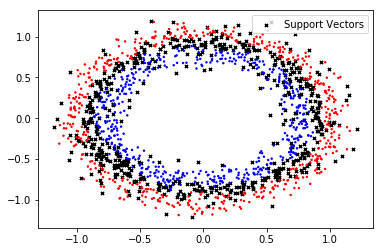

In [29]:
clf.visualize_support_vectors()